# Parte 2: Para la guía autónoma

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# =========================================
# 1) Datos
# =========================================
# Ahora: leemos Online Retail y construimos RFM por cliente
raw = pd.read_csv("Online Retail.csv", encoding="ISO-8859-1")
raw.columns = [c.strip() for c in raw.columns]

# Limpieza mínima para RFM
raw = raw.dropna(subset=["CustomerID"])                            # necesitamos cliente
raw = raw[(raw["Quantity"] > 0) & (raw["UnitPrice"] > 0)]          # solo compras válidas
raw["InvoiceDate"] = pd.to_datetime(raw["InvoiceDate"], errors="coerce")
raw = raw.dropna(subset=["InvoiceDate"])
raw["TotalPrice"] = raw["Quantity"] * raw["UnitPrice"]

# Fecha de referencia (día siguiente al último registro)
snapshot_date = raw["InvoiceDate"].max() + pd.Timedelta(days=1)

# Agregación RFM por cliente
rfm = (
    raw.groupby("CustomerID").agg(
        Recency=("InvoiceDate", lambda s: (snapshot_date - s.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("TotalPrice", "sum"),
    )
    .reset_index()
)

# Para mantener tu patrón de variables:
df = rfm.copy()

# Selección de variables (pueden ser >3) usamos RFM
features = ['Recency', 'Frequency', 'Monetary']
X = df[features].to_numpy()

# Escalado (muy importante)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled listo para KMeans / evaluación de k

In [ ]:
# =========================================
# 2) Barrido de k
# =========================================
max_k = min(8, len(df) - 1)
ks = range(2, max_k + 1)
sse = []
sils = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    sse.append(model.inertia_)
    sils.append(silhouette_score(X_scaled, labels))



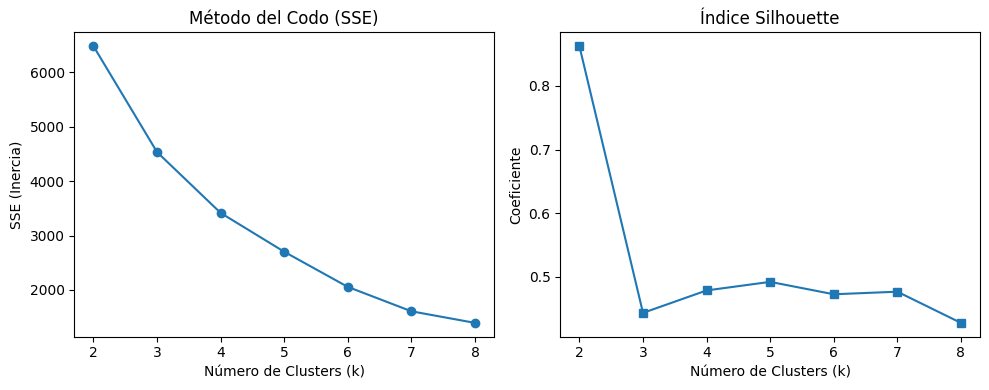

In [ ]:
# =========================================
# 3) Gráficos de evaluación
# =========================================
plt.figure(figsize=(10,4))

# (a) Método del Codo
plt.subplot(1,2,1)
plt.plot(ks, sse, "o-")
plt.title("Método del Codo (SSE)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("SSE (Inercia)")

# (b) Silhouette
plt.subplot(1,2,2)
plt.plot(ks, sils, "s-")
plt.title("Índice Silhouette")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Coeficiente")

plt.tight_layout()
plt.show()

In [ ]:
# =========================================
# 4) Selección automática (máx silhouette)
# =========================================
best_k = ks[np.argmax(sils)]
print(f"Mejor k sugerido (por Silhouette): {best_k}")

# Forzar prueba manual con k=4 para más subniveles
best_k = 4

Mejor k sugerido (por Silhouette): 2


In [ ]:
# =========================================
# 5) Modelo final
# =========================================
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = final_kmeans.fit_predict(X_scaled)
df["Cluster"] = labels
centroids = scaler.inverse_transform(final_kmeans.cluster_centers_)

centroids

array([[8.64171867e+01, 2.73451752e+00, 1.05032264e+03],
       [3.28671694e+02, 1.27958237e+00, 4.46007807e+02],
       [4.47142857e+01, 2.25306122e+01, 1.85952486e+04],
       [6.10000000e+01, 1.93333333e+01, 1.30680010e+05]])

In [ ]:
# =========================================
# 5.1) Nombrar segmentos (k=4) y exportar
# =========================================

# ranking de valor: Monetary alto (desc), Recency bajo (asc)
cent_df = pd.DataFrame(centroids, columns=features)
score = cent_df["Monetary"].rank(ascending=False) + cent_df["Recency"].rank(ascending=True)
orden = score.sort_values().index.tolist()  # mejor -> peor

nombres = ["Premium", "Activos", "Ocasionales", "Perdidos"]
mapa = {orden[i]: nombres[i] for i in range(4)}

# detectar micro-cluster muy pequeño, renombrar como VIP Élite:
sizes = df["Cluster"].value_counts().to_dict()
for c, n in sizes.items():
    if n <= 10:  # umbral simple
        mapa[c] = "VIP Élite"

df["Segmento"] = df["Cluster"].map(mapa)

# Exporta resultados
out_cols = ["CustomerID", "Recency", "Frequency", "Monetary", "Cluster", "Segmento"]
df[out_cols].to_csv("segmentos_rfm_k4.csv", index=False)
print("Archivo generado: segmentos_rfm_k4.csv")
print("Distribución de segmentos:")
print(df["Segmento"].value_counts())

Archivo generado: segmentos_rfm_k4.csv
Distribución de segmentos:
Segmento
Ocasionales    2083
Perdidos        862
Activos          49
VIP Élite         3
Name: count, dtype: int64


In [ ]:
# =========================================
# 6) Reporte tipo WEKA (dinámico)
# =========================================
print(f"Silhouette (k={best_k}): {silhouette_score(X_scaled, labels):.3f}")
print("Tamaño por clúster:", df["Cluster"].value_counts().sort_index().to_dict(), "\n")

print("Cluster centroids:")
header = "Variable".ljust(15) + "".join([f" {i:>6}" for i in range(len(centroids))])
print(header)
print("-" * len(header))

for j, var in enumerate(features):
    row = f"{var:<15}" + "".join([f"{centroids[i][j]:>7.1f}" for i in range(len(centroids))])
    print(row)

Silhouette (k=4): 0.479
Tamaño por clúster: {0: 2083, 1: 862, 2: 49, 3: 3} 

Cluster centroids:
Variable             0      1      2      3
-------------------------------------------
Recency           86.4  328.7   44.7   61.0
Frequency          2.7    1.3   22.5   19.3
Monetary        1050.3  446.018595.2130680.0


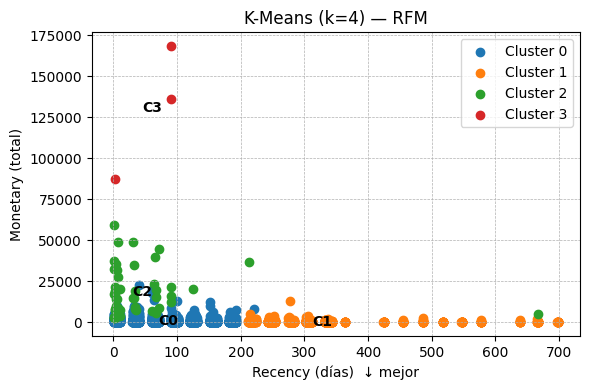

In [ ]:
# =========================================
# 7) Gráfico (un solo plot, sin especificar colores)
# =========================================
# Usaremos Recency (x) vs Monetary (y)
x_var, y_var = "Recency", "Monetary"
ix, iy = features.index(x_var), features.index(y_var)

# Asegurar que 'centroids' sea array para tomar R y M
try:
    cent_arr = centroids.values   # si es DataFrame
except AttributeError:
    cent_arr = centroids          # si ya es ndarray

plt.figure(figsize=(6,4))

for lab in np.unique(labels):
    m = (labels == lab)
    plt.scatter(df.loc[m, x_var], df.loc[m, y_var], label=f"Cluster {lab}")

# Anotar centroides en (Recency, Monetary)
for i in range(cent_arr.shape[0]):
    cx, cy = cent_arr[i, ix], cent_arr[i, iy]
    plt.annotate(f"C{i}", (cx, cy),
                 xytext=(0,0), textcoords="offset points",
                 ha="center", va="center", fontsize=10, fontweight="bold")

plt.title(f"K-Means (k={best_k}) — RFM")
plt.xlabel("Recency (días)  ↓ mejor")
plt.ylabel("Monetary (total)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df

,CustomerID,Recency,Frequency,Monetary,Cluster,Segmento
0,12347.0,96,5,2540.29,0,Ocasionales
1,12348.0,221,1,367.00,1,Perdidos
2,12350.0,312,1,334.40,1,Perdidos
3,12352.0,275,3,1296.38,1,Perdidos
4,12355.0,97,1,459.40,0,Ocasionales
...,...,...,...,...,...,...
2992,18280.0,161,1,180.60,0,Ocasionales
2993,18281.0,5,1,80.82,0,Ocasionales
2994,18282.0,217,2,178.05,1,Perdidos
2995,18283.0,61,5,565.65,0,Ocasionales


In [ ]:
# =========================================
# Asignar nombres interpretativos a los clusters
# =========================================

name_map = {
    0: "Clientes Ocasionales (recencia media, gasto medio)",
    1: "Clientes Perdidos (recencia alta, gasto bajo)",
    2: "Clientes Activos o Premium (recientes, gasto alto)",
    3: "Clientes VIP Élite (muy alto gasto, pocos casos)",
}

df["Grupo"] = df["Cluster"].map(name_map)
df.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segmento,Grupo
0,12347.0,96,5,2540.29,0,Ocasionales,"Clientes Ocasionales (recencia media, gasto me..."
1,12348.0,221,1,367.00,1,Perdidos,"Clientes Perdidos (recencia alta, gasto bajo)"
2,12350.0,312,1,334.40,1,Perdidos,"Clientes Perdidos (recencia alta, gasto bajo)"
3,12352.0,275,3,1296.38,1,Perdidos,"Clientes Perdidos (recencia alta, gasto bajo)"
4,12355.0,97,1,459.40,0,Ocasionales,"Clientes Ocasionales (recencia media, gasto me..."


In [ ]:
# === Predicción con nuevos clientes (RFM) ===
# Requiere: features, scaler (fit) y final_kmeans (fit). Opcional: name_map/mapa

features = ["Recency", "Frequency", "Monetary"]

# Si en tu notebook el diccionario se llama 'mapa' (del paso 5.1),
# lo exponemos como name_map para reutilizar este bloque sin cambios extra.
name_map = globals().get("name_map", globals().get("mapa", None))

# 1) Un cliente nuevo (RFM ya calculado)
nuevo = pd.DataFrame([{"Recency": 30, "Frequency": 6, "Monetary": 1500.0}])
Z = scaler.transform(nuevo[features])                 # mismo orden de columnas
lab = int(final_kmeans.predict(Z)[0])
nombre = name_map.get(lab, f"C{lab}") if name_map is not None else f"C{lab}"
print("Cluster asignado:", lab, "-", nombre)

# 2) Varios clientes nuevos (batch)
nuevos = pd.DataFrame([
    {"Recency": 10,  "Frequency": 12, "Monetary": 5200.0},
    {"Recency": 180, "Frequency":  2, "Monetary":  300.0},
    {"Recency": 60,  "Frequency": 20, "Monetary": 9000.0},
])
Zb = scaler.transform(nuevos[features])
labs = final_kmeans.predict(Zb)
nuevos["Cluster"] = labs
if name_map is not None:
    nuevos["Grupo"] = nuevos["Cluster"].map(name_map)

display(nuevos)


Cluster asignado: 0 - Clientes Ocasionales (recencia media, gasto medio)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Recency,Frequency,Monetary,Cluster,Grupo
0,10,12,5200.0,0,"Clientes Ocasionales (recencia media, gasto me..."
1,180,2,300.0,0,"Clientes Ocasionales (recencia media, gasto me..."
2,60,20,9000.0,2,"Clientes Activos o Premium (recientes, gasto a..."


In [ ]:
# === (A) GUARDAR artefactos tras entrenar ===
# Requiere que ya tengas: features, scaler (fit), final_kmeans (fit)
import joblib, json

joblib.dump(scaler, "scaler.joblib")
joblib.dump(final_kmeans, "kmeans_final.joblib")
with open("features.json", "w") as f:
    json.dump(features, f)

# (opcional) si creaste un diccionario de nombres de cluster
if 'name_map' in globals():
    joblib.dump(name_map, "cluster_name_map.joblib")


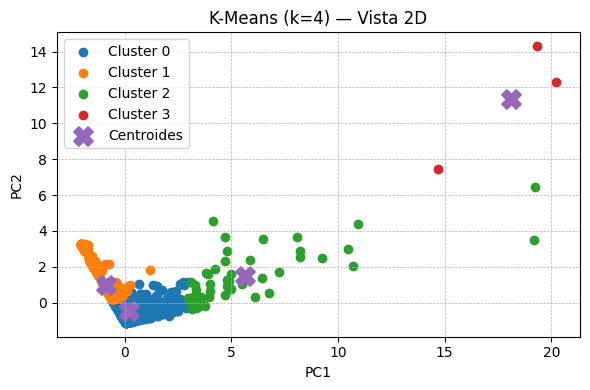

In [ ]:
# =========================================
# 8) Gráfico dinámico (un solo plot, sin especificar colores)
#    - Si hay 2 features: usa esas como ejes
#    - Si hay >2 features: usa PCA(2D) sobre X_scaled y transforma los centroides
# =========================================
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

if len(features) == 2:
    x_ax, y_ax = features
    X_plot = X                              # en escala original
    C_plot = centroids                      # centroides ya reescalados
    xlabel, ylabel = x_ax, y_ax
else:
    pca = PCA(n_components=2, random_state=42)
    X_plot = pca.fit_transform(X_scaled)    # puntos en 2D (PCA)
    C_plot = pca.transform(final_kmeans.cluster_centers_)  # centroides en el mismo 2D
    xlabel, ylabel = "PC1", "PC2"

for lab in np.unique(labels):
    m = labels == lab
    plt.scatter(X_plot[m, 0], X_plot[m, 1], label=f"Cluster {lab}")

plt.scatter(C_plot[:, 0], C_plot[:, 1], marker="X", s=180, linewidths=1.5, label="Centroides")

plt.title(f"K-Means (k={best_k}) — Vista 2D")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# 🧩 Segmentación de Clientes (RFM)

## 🧠 1. Entendimiento del Negocio
**Objetivo:**  
Segmentar a los clientes de una tienda online según sus patrones de compra utilizando el modelo **RFM (Recency, Frequency, Monetary)**, con el fin de identificar grupos con diferente valor comercial.

**Beneficio:**  
Permite diseñar estrategias de marketing personalizadas para fidelizar, retener o reactivar clientes.

---

## 🧩 2. Entendimiento de los Datos
**Dataset:** `Online Retail.csv`  
**Tamaño:** 541,909 filas × 9 columnas  
**Período:** 2010-01-12 → 2011-12-10  

**Principales columnas:**  
`InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`.

**Análisis inicial:**
- 5,268 duplicados  
- 135,080 clientes sin ID  
- 10,624 devoluciones (Quantity < 0)  
- 2,517 precios ≤ 0  

---

## 🧹 3. Preparación de los Datos
1. Se filtraron ventas válidas (`Quantity > 0`, `UnitPrice > 0`, `CustomerID` no nulo).  
2. Se creó `TotalPrice = Quantity × UnitPrice`.  
3. Se calcularon los indicadores RFM por cliente:
   - **Recency:** días desde la última compra.  
   - **Frequency:** número de facturas.  
   - **Monetary:** gasto total (£).  
4. Se obtuvo un dataset limpio de **2,997 clientes únicos**.

---

## 🤖 4. Modelado (K-Means)
- Se escalaron las variables RFM con `StandardScaler()`.  
- Se evaluaron valores de *k* entre 2 y 8:
  - **Método del Codo:** tendencia a estabilizarse en *k = 4–5*.  
  - **Índice de Silhouette:** máximo en *k = 2* (0.86).  
- Se seleccionó **k = 4** para lograr una segmentación más detallada.

---

## 📈 5. Resultados del Modelo (k = 4)
| Cluster | Recency (d) | Frequency | Monetary (£) | Nº clientes | Segmento |
|----------|--------------|------------|---------------|-------------|-----------|
| 0 | 86 | 2.7 | 1,050 | 2,083 | Ocasionales |
| 1 | 329 | 1.3 | 446 | 862 | Perdidos |
| 2 | 45 | 22 | 18,595 | 49 | Activos/Premium |
| 3 | 61 | 19 | 130,680 | 3 | VIP Élite |

**Silhouette(k=4) = 0.479** → buena separación, con un micro-cluster de alto valor.

---

## 🏷️ 6. Segmentos de Clientes
- **Perdidos:** inactivos, bajo gasto.  
- **Ocasionales:** base amplia, compras esporádicas.  
- **Activos/Premium:** frecuentes, gasto alto.  
- **VIP Élite:** muy pocos, gasto extraordinario.  

**Archivo exportado:** `segmentos_rfm_k4.csv`

---

## 💾 7. Guardado de Artefactos
Se almacenaron los modelos entrenados para uso futuro:
model_artifacts/
├── scaler.joblib
├── kmeans_final.joblib
├── features.json
└── cluster_name_map.joblib

Estos artefactos permiten **predecir nuevos clientes** sin re-entrenar el modelo.

---

## 🔮 8. Predicción con Nuevos Clientes
Se implementó un bloque para clasificar nuevos registros RFM:


nuevo = {"Recency": 30, "Frequency": 6, "Monetary": 1500}
# Resultado → Cluster 0 — Clientes Ocasionales
---

## 📊 9. Visualizaciones

### 🔹 Gráfico RFM 2D (Recency vs Monetary)
El gráfico muestra la distribución de los clientes en función de su **Recency** (tiempo desde la última compra) y su **Monetary** (gasto total).  
Se observan cuatro grupos claramente diferenciados:

- **Cluster 0 – Ocasionales:** mayoría de clientes, gasto bajo y compras esporádicas.  
- **Cluster 1 – Perdidos:** clientes con alta recencia (no compran hace mucho), bajo gasto.  
- **Cluster 2 – Activos o Premium:** clientes recientes, frecuentes y con alto gasto.  
- **Cluster 3 – VIP Élite:** pocos clientes con gasto extremadamente alto.

Este gráfico permite identificar la relación entre la **frecuencia de compra** y el **valor económico** del cliente, siendo una herramienta útil para priorizar estrategias de fidelización o reactivación.

### 🔹 Gráfico PCA 2D (Vista general)
Mediante **Análisis de Componentes Principales (PCA)** se redujeron las tres dimensiones RFM a dos componentes principales.  
El gráfico PCA muestra cómo los clusters se separan visualmente en el espacio bidimensional:

- Los **clientes VIP (Cluster 3)** aparecen aislados del resto debido a su alto valor monetario.  
- Los **clusters 0 y 1** se superponen parcialmente, lo que refleja perfiles de gasto similares, aunque con diferente recencia.  
- El **cluster 2 (Premium)** se mantiene bien definido, con clientes de alta frecuencia y gasto significativo.

Estas visualizaciones confirman la **coherencia y consistencia del modelo K-Means**, validando la elección de *k = 4*.

---

## 🧾 10. Conclusiones

1. El modelo **K-Means (k = 4)** permitió realizar una **segmentación efectiva** de los clientes de la tienda online utilizando el enfoque **RFM (Recency, Frequency, Monetary)**.
2. Los **cuatro grupos** obtenidos (Ocasionales, Perdidos, Premium y VIP Élite) representan **niveles crecientes de valor y compromiso** con la empresa.
3. El modelo presenta una **buena calidad de segmentación** (*Silhouette = 0.479*), con clara diferenciación de los grupos más valiosos.
4. Los resultados son **accionables** para estrategias de marketing:
   - **VIP Élite:** programas de fidelización personalizados o recompensas exclusivas.  
   - **Premium:** mantener con promociones selectivas y atención preferente.  
   - **Ocasionales:** incentivar con descuentos o recordatorios.  
   - **Perdidos:** campañas de reactivación o depuración del mailing.
5. Se implementaron procesos de **escalado, modelado, visualización y guardado de artefactos**, completando el ciclo **CRISP-DM** hasta la fase de **Despliegue**.
6. El modelo puede reutilizarse fácilmente para **clasificar nuevos clientes** mediante los artefactos guardados (`scaler.joblib`, `kmeans_final.joblib`, `features.json` y `cluster_name_map.joblib`).

**Conclusión final:**  
> El análisis RFM combinado con K-Means logró identificar patrones claros de comportamiento en los clientes, aportando una base sólida para decisiones estratégicas orientadas al valor del cliente y la optimización de recursos de marketing.